In [30]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)

import cmasher as cmr



In [31]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [32]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [33]:
def plot_scatter_data(data_df, x_col="x", y_col="y", x_lim=None, x_tick_spec=None,y_lim=None,y_tick_spec=None,x_name=None,y_name=None, series_readable_id_col="name",infer_sort_by_x=True, plot_inferred_series=False, inferred_series_linewidth=None, inferred_series_linestyle=None, series_readable_id_map=None, special_color_map=None, color_marker_map=None, num_colors=None, num_markers=None, num_cols=None, filter_list=None, legend_sort_indices=None, shorten_legend_indices=None, legend_unique_indices=None, title="Figure Title", marker_size=None,figure_size=None,legend_loc=None, grid=True, save_path=None, show=True):
    
    # give each point a unique marker and color
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    # markers = ["*", "s", "^", "p", "v", "<", "P", ">", "h", "H", "+",  "X", "D",  "|", "d", "x", "_", "o"]
    markers = ["*", "s",  "X", "D",  "P", ">", "h", "^","v", "p", "<", "H", "+", "d", "x", "p"]


    if num_markers is not None:
        markers = markers[:num_markers]
    
    all_possible_color_and_marker_combos = [(color, marker) for color in cmap for marker in markers]
    
    #plot using plt.scatter
    # make figsize larger if num_cols is not None adn num_cols > 1
    #  and scale marker size
    if num_cols > 1:
        fig, ax = plt.subplots(figsize=(8*num_cols, 6))
        marker_size = 50
    else:
        fig, ax = plt.subplots(figsize=figure_size)
        marker_size = marker_size
    
    # sort data_df by series_readable_id_col
    # data_df = data_df.sort_values(by=[series_readable_id_col])

    if filter_list is not None:
        # remove data where series_readable_id_map[row[series_readable_id_col]] is in filter_list
        # print(f"Col for filtering:{data_df[series_readable_id_col].apply(series_readable_id_map)[0]}")
        data_df = data_df[~data_df[series_readable_id_col].apply(series_readable_id_map).isin(filter_list)]


    if plot_inferred_series:
        series_df = pd.DataFrame()

    for i, row in data_df.iterrows():

        if isinstance(series_readable_id_map, dict):
            label = series_readable_id_map[row[series_readable_id_col]]
        elif isinstance(series_readable_id_map, Callable):
            # print(row[series_readable_id_col])
            label = series_readable_id_map(row[series_readable_id_col])
            # print(label)
        else:
            label = row[series_readable_id_col]
        
        if color_marker_map is not None and isinstance(color_marker_map, Callable):
            # print(f"Using color marker callable")
            color_idx, marker_idx = color_marker_map(series_readable_id_map(row[series_readable_id_col]))
            if isinstance(color_idx,int):
                color = cmap[color_idx]
            else:
                color = color_idx
            if isinstance(marker_idx,int):
                marker = markers[marker_idx]
            else:
                marker = marker_idx
            # print(f"color: {color}, marker: {marker}")
        else:
            if special_color_map and row[series_readable_id_col] in special_color_map.keys():
                if isinstance(special_color_map[row[series_readable_id_col]], int):
                    color = cmap[special_color_map[row[series_readable_id_col]]]
                else:
                    color = special_color_map[row[series_readable_id_col]]
            else:
                # color = cmap[i]
                color = all_possible_color_and_marker_combos[i][0]
            # marker = markers[i]
            marker = all_possible_color_and_marker_combos[i][1]

        if plot_inferred_series:
            # append a row to the series_dict where the label elements are the cols
            #  and the x and y cols are the values
            series_entry = {}
            series_entry.update({i:label.split(",")[i] for i in legend_unique_indices})
            series_entry.update({x_col:row[x_col], y_col:row[y_col]})
            # add the color and marker
            series_entry.update({"color":color, "marker":marker})
            series_df = series_df.append(series_entry, ignore_index=True)

        ax.scatter(row[x_col], row[y_col], label=label, color=color, marker=marker, alpha=0.8, sizes=[marker_size], zorder=2)

    
    # sort legend the value of y_col and then x_col
    handles, labels = ax.get_legend_handles_labels()
    x_vals = data_df[x_col]
    y_vals = data_df[y_col]

    if legend_sort_indices is not None:
        label_tups = [lab.split(",") for lab in labels]
        # label_tups = [tuple([lab[i] for i in legend_name_indices]) for lab in label_tups]
        # sort by label_tups in their order
        # handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: [[t[1][i] for i in legend_sort_indices],t[2]], reverse=False))
        # handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: ([[t[1][i] for i in legend_sort_indices],t[2]] if t[1][0] != "simple" else [["00000",-1],-1]), reverse=False))
        handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: ([[t[1][i] for i in legend_sort_indices],t[2]] if not("Simple" in t[1][0]) else [["00000",-1],-1]), reverse=False))
        if legend_unique_indices:
            legend_dict = {tuple([label_tup[i] for i in legend_unique_indices]): [handle,label_tup] for handle,label_tup in zip(handles,label_tups)}
            handles, label_tups = zip(*legend_dict.values())
        if shorten_legend_indices:
            label_tups = [[lab[i] for i in shorten_legend_indices] for lab in label_tups]
        labels = [",".join(lab) for lab in label_tups]
        legend_title = f""
    else:
        # sort by x/y_vals
        handles, labels, _, _ = zip(*sorted(zip(handles, labels, x_vals, y_vals), key=lambda t: (t[3],t[2]), reverse=True))
        legend_title = f"(Sorted desc. by {y_name if y_name else y_col})"


    # if plot_inferred_series, then using the legend_unique_indices, group the series_dict by those indices
    # sort by the x_col value, and then plot the series as line with the same color and marker as the scatter
    # do a check to make sure that the color and marker are all the same within each group
    if plot_inferred_series:
        # first group by the legend_unique_indices
        grouped_series_df = series_df.groupby(list(legend_unique_indices))
        # print(grouped_series_df.groups)
        # for each group, sort by the x_col value
        for group_name, group_df in grouped_series_df:
            group_df = group_df.sort_values(by=(x_col if infer_sort_by_x else y_col))
            # if group_df["color"].nunique() == 1 and group_df["marker"].nunique() == 1:
            #     # ax.plot(group_df[x_col], group_df[y_col], color=group_df["color"].iloc[0], marker=group_df["marker"].iloc[0], alpha=0.8, linewidth=inferred_series_linewidth)
            ax.plot(group_df[x_col], group_df[y_col], color=group_df["color"].iloc[-1], alpha=0.8, linewidth=inferred_series_linewidth, linestyle=inferred_series_linestyle, zorder=1)
            # else:
            #     print(f"Group {group_name} has more than one color/marker combination. Not plotting line.")




    # sort by labels if num_cols more than 1, make the legend outside the plot to the RHS
    # and increase marker size
    if num_cols > 1:
        # ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols)
        # make legend taller
        ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols, handletextpad=0.1, columnspacing=0.2, title=legend_title, fontsize=12)
    else:
        ax.legend(handles, labels,loc=legend_loc, ncol=(num_cols if num_cols is not None else 1), title=legend_title, fontsize=12)
    
    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_name if x_name else x_col)
    plt.ylabel(y_name if y_name else y_col)

    # set x and y limits
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    if x_tick_spec is not None:
        ax.set_xticks(x_tick_spec)
    if y_tick_spec is not None:
        ax.set_yticks(y_tick_spec)

    # turn on grid
    ax.set_axisbelow(True)
    ax.grid(grid,zorder=0)

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [34]:
def name_extractor(x):

    is_ff = "ff" in x
    is_simple = "simple" in x
    
    x = x.replace("scheme_ff-", "")
    x = x.replace("_gen_eval", "")
    x = x.replace("_50_200", "")
    x = x.replace("scheme_", "")
    x = x.replace("core_", "")
    x = x.replace("anchored_", "anchored-")
    x = x.replace("_prf-", "-prf_")
    x = x.replace("-True", "_True")
    x = x.replace("-False", "_False")

    x = x.replace("simple", "Additive-LeftHash")
    x = x.replace("anchored-minhash-prf", "Min-SelfHash")
    # x = x.replace("anchored-minhash-prf", "Anchored-Min-SelfHash")
    x = x.replace("minhash-prf", "Min-LeftHash")
    x = x.replace("anchored-skipgram-prf", "Skip-SelfHash")
    # x = x.replace("anchored-skipgram-prf", "Anchored-Skip-SelfHash")
    x = x.replace("skipgram-prf", "Skip-LeftHash")

    tup_x = x.split("_")
    tup_x[-1] = tup_x[-1].replace("-", ".")
    tup_x[-2] = tup_x[-2].replace("-", ".")

    
    # turn into a dict repr

    if is_ff:
        x_dict = {
            "prf_type": tup_x[0],
            "context_width": tup_x[1],
            "self_salt": tup_x[2],
            "gamma": tup_x[3],
            "delta": tup_x[4],
        }
    elif is_simple:
        x_dict = {
            "prf_type": tup_x[0],
            # "prf_type": "additive_prf",
            "context_width": tup_x[1],
            "self_salt": False,
            "gamma": tup_x[2],
            "delta": tup_x[3],
        }
    else:
        raise ValueError(f"Invalid scheme name {x} found.")
    
    # return x_dict
    return ",".join([str(elm) for elm in x_dict.values()])


In [35]:
fig_name = "scheme_z_psp_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

In [26]:
# name_col = df["Name"]
name_col = df["Name"].apply(name_extractor)
# name_col

In [27]:
# (prf_type, context_width, self_salt, gamma, delta)

In [28]:
color_order = [(typ,width) for width in [1,2,3,4] for typ in [
    # "simple",
    # "anchored-minhash-prf",
    # "minhash-prf",
    # "anchored-skipgram-prf",
    # "skipgram-prf",
    "Min-SelfHash",
    # "Anchored-Min-SelfHash",
    "Min-LeftHash",
    "anchored-skipgram-prf",
    "Skip-LeftHash",
]]

marker_order = color_order

# marker_order = [
#     [0.5,1.0],
#     [0.5,2.0],
#     [0.5,4.0],
#     [0.25,1.0],
#     [0.25,2.0],
#     [0.25,4.0],
#     [0.1,1.0],
#     [0.1,2.0],
#     [0.1,4.0],
# ]


def color_marker_map(x):

    x_tup = x.split(",")
    assert len(x_tup) == 5

    prf_type = x_tup[0]
    context_width = x_tup[1]
    self_salt = x_tup[2]
    gamma = x_tup[3]
    delta = x_tup[4]


    if prf_type == "Additive-LeftHash" and context_width == "1" and self_salt == "False":
        color = "black"
        marker = "o"
    else:
        color = color_order.index((prf_type, int(context_width)))
        # color = color_order.index([float(gamma), float(delta)])
        # color = color_order.index(prf_type)

        # marker = marker_order.index([float(gamma), float(delta)])
        marker = marker_order.index((prf_type, int(context_width)))
        # marker = marker_order.index(int(context_width))
        # marker = "o"

    return color, marker

filter_list = [
    "Min-SelfHash,1,True,0.1,1.0",
    "Min-SelfHash,1,True,0.5,1.0",
    "Min-SelfHash,1,True,0.25,1.0",
    "Min-SelfHash,1,True,0.1,2.0",
    "Min-SelfHash,1,True,0.5,2.0",
    "Min-SelfHash,1,True,0.25,2.0",
    "Min-SelfHash,1,True,0.1,4.0",
    "Min-SelfHash,1,True,0.5,4.0",
    "Min-SelfHash,1,True,0.25,4.0",
]

# filter_list = [f"Anchored-{elm}" for elm in filter_list]
    

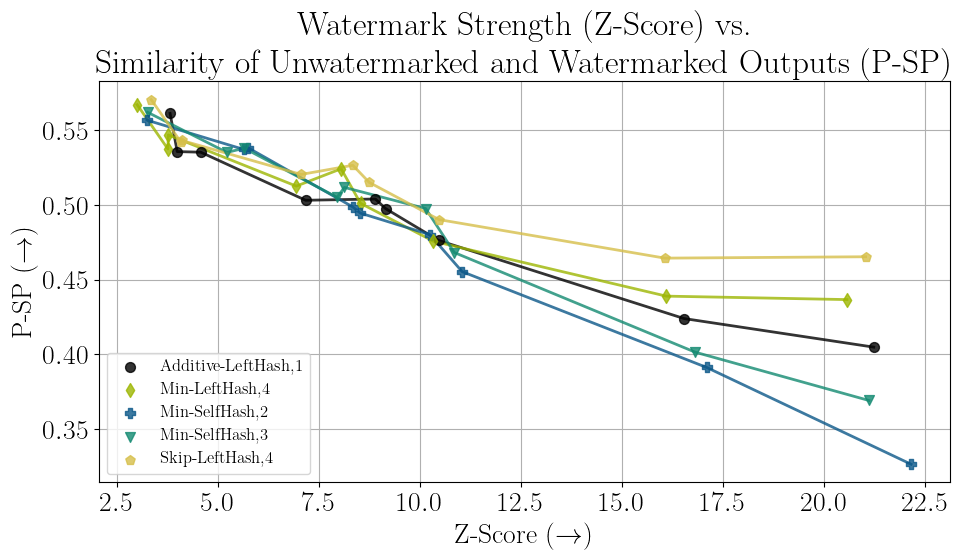

In [29]:
plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_no_wm_output_vs_w_wm_output_p_sp_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"P-SP $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=16,
    num_markers=16,
    num_cols=1,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="lower left",
    title="Watermark Strength (Z-Score) vs.\nSimilarity of Unwatermarked and Watermarked Outputs (P-SP)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [30]:
fig_name = "scheme_z_logdiv_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,Name,f_200p25m25_w_wm_output_z_score_mean,f_200p25m25_w_wm_output_log_diversity_mean,_wandb
0,scheme_simple_1_0-25_2-0_gen_eval,9.154518,7.062260,NaN
1,scheme_ff-anchored_minhash_prf-1-True_0-25_4-0...,16.305206,5.147162,NaN
2,scheme_simple_1_0-1_2-0_gen_eval,8.903747,7.045435,NaN
3,scheme_ff-anchored_minhash_prf-1-True_0-25_2-0...,9.666355,6.339381,NaN
4,scheme_ff-skipgram_prf-4-False_0-5_4-0_gen_eval,10.477429,8.511528,NaN
5,scheme_ff-anchored_minhash_prf-3-True_0-25_4-0...,16.813516,5.945290,NaN
6,scheme_ff-minhash_prf-4-False_0-5_2-0_gen_eval,6.946856,7.732350,NaN
7,scheme_ff-anchored_minhash_prf-3-True_0-5_2-0_...,7.955319,6.775775,NaN
8,scheme_ff-skipgram_prf-4-False_0-1_2-0_gen_eval,8.344920,7.751965,NaN
9,scheme_simple_1_0-25_4-0_gen_eval,16.539055,6.349438,NaN


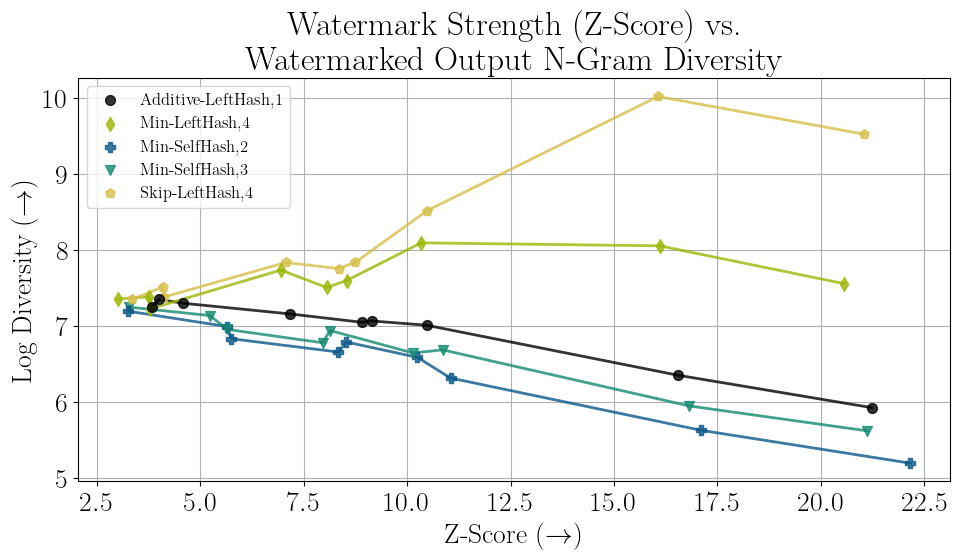

In [31]:

plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_w_wm_output_log_diversity_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"Log Diversity $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=16,
    num_markers=16,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="upper left",
    num_cols=1,
    title="Watermark Strength (Z-Score) vs.\nWatermarked Output N-Gram Diversity",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [32]:
fig_name = "scheme_z_repetition2_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

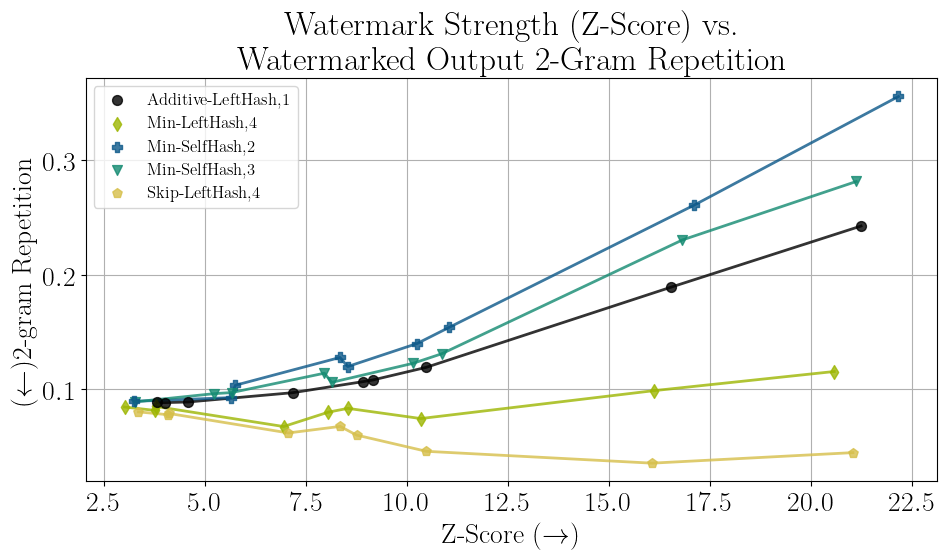

In [33]:

plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_w_wm_output_repetition_2_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"$(\leftarrow) $2-gram Repetition",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=16,
    num_markers=16,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="upper left",
    num_cols=1,
    title="Watermark Strength (Z-Score) vs.\nWatermarked Output 2-Gram Repetition",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

### Extended Scheme Runs

In [6]:
# def name_extractor(x):

#     is_ff = "ff" in x
#     is_simple = "simple" in x
    
#     x = x.replace("scheme_ff-", "")
#     x = x.replace("_gen_eval", "")
#     x = x.replace("_50_200", "")
#     x = x.replace("scheme_", "")
#     x = x.replace("core_", "")
#     x = x.replace("anchored_", "anchored-")
#     x = x.replace("_prf-", "-prf_")
#     x = x.replace("-True", "_True")
#     x = x.replace("-False", "_False")

#     x = x.replace("simple_1", "Simple_1")
#     x = x.replace("anchored-minhash-prf", "Min-SelfHash")
#     x = x.replace("minhash-prf", "Min-LeftHash")
#     x = x.replace("skipgram-prf", "Skip-LeftHash")
#     x = x.replace("additive-prf", "Additive-LeftHash")

#     tup_x = x.split("_")
#     tup_x[-1] = tup_x[-1].replace("-", ".")
#     tup_x[-2] = tup_x[-2].replace("-", ".")

    
#     # turn into a dict repr

#     if is_ff:
#         x_dict = {
#             "prf_type": tup_x[0],
#             "context_width": tup_x[1],
#             "self_salt": tup_x[2],
#             "gamma": tup_x[3],
#             "delta": tup_x[4],
#         }
#     elif is_simple:
#         x_dict = {
#             "prf_type": tup_x[0],
#             # "prf_type": "additive_prf",
#             "context_width": tup_x[1],
#             "self_salt": False,
#             "gamma": tup_x[2],
#             "delta": tup_x[3],
#         }
#     else:
#         raise ValueError(f"Invalid scheme name {x} found.")
    
#     # return x_dict
#     return ",".join([str(elm) for elm in x_dict.values()])


In [21]:
# # color_order = [(typ,width) for width in [1,2,4,8] for typ in [
# #     "Min-LeftHash",
# #     "Skip-LeftHash",
# #     "Additive-LeftHash",
# # ]]
# color_order = [
#     "Additive-LeftHash",
#     "Skip-LeftHash",
#     "Min-LeftHash",
# ]

# marker_order = color_order

# # marker_order = [
# #     [0.5,1.0],
# #     [0.5,2.0],
# #     [0.5,4.0],
# #     [0.25,1.0],
# #     [0.25,2.0],
# #     [0.25,4.0],
# #     [0.1,1.0],
# #     [0.1,2.0],
# #     [0.1,4.0],
# # ]


# def color_marker_map(x):

#     x_tup = x.split(",")
#     assert len(x_tup) == 5

#     prf_type = x_tup[0]
#     context_width = x_tup[1]
#     self_salt = x_tup[2]
#     gamma = x_tup[3]
#     delta = x_tup[4]


#     if prf_type == "Simple" or (prf_type == "Additive-LeftHash" and context_width=="1" and self_salt == "False"):
#         color = "black"
#         marker = "o"
#     else:
#         color = color_order.index(prf_type)
#         marker = marker_order.index(prf_type)
#     return color, marker

# filter_list = [
#     "Simple,1,False,0-25,4-0",
# ]

In [36]:
def name_extractor(x):

    is_ff = "ff" in x
    is_simple = "simple" in x
    is_algo3 = "algorithm" in x
    is_self_salted = "True" in x
    if is_algo3:
        is_self_salted = True
    
    x = x.replace("scheme_ff-", "")
    x = x.replace("_gen_eval", "")
    x = x.replace("_50_200", "")
    x = x.replace("scheme_", "")
    x = x.replace("core_", "")
    x = x.replace("anchored_", "anchored-")
    x = x.replace("_prf-", "-prf_")
    x = x.replace("-True", "_True")
    x = x.replace("-False", "_False")

    x = x.replace("algorithm-3", "Algorithm3")
    x = x.replace("simple_1", "Simple_1")
    
    if is_self_salted:
        x = x.replace("-prf","-SelfHash")
    else:
        x = x.replace("-prf","-LeftHash")

    x = x.replace("minhash", "Min")
    x = x.replace("skipgram", "Skip")
    x = x.replace("additive", "Additive")
    # x = x.replace("anchored", "Anchored")
    x = x.replace("anchored-", "")


    tup_x = x.split("_")
    tup_x[-1] = tup_x[-1].replace("-", ".")
    tup_x[-2] = tup_x[-2].replace("-", ".")

    
    # turn into a dict repr

    if is_ff:
        x_dict = {
            "prf_type": tup_x[0],
            "context_width": tup_x[1],
            "self_salt": tup_x[2],
            "gamma": tup_x[3],
            "delta": tup_x[4],
        }
    elif is_simple:
        x_dict = {
            "prf_type": tup_x[0],
            # "prf_type": "additive_prf",
            "context_width": tup_x[1],
            "self_salt": False,
            "gamma": tup_x[2],
            "delta": tup_x[3],
        }
    elif is_algo3:
        x_dict = {
            "prf_type": tup_x[0],
            "context_width": 4,
            "self_salt":True,
            "gamma": tup_x[1],
            "delta": tup_x[2],
        }
    else:
        raise ValueError(f"Invalid scheme name {x} found.")
    
    # return x_dict
    return ",".join([str(elm) for elm in x_dict.values()])


In [37]:
# color_order = [(typ,width) for width in [1,2,4,8] for typ in [
#     "Min-LeftHash",
#     "Skip-LeftHash",
#     "Additive-LeftHash",
# ]]
color_order = [
    "Additive-LeftHash",
    "Additive-SelfHash",
    "Anchored-Skip-LeftHash",
    "Anchored-Skip-SelfHash",
    "Skip-LeftHash",
    "Skip-SelfHash",
    "Anchored-Min-LeftHash",
    "Anchored-Min-SelfHash",
    "Min-LeftHash",
    "Min-SelfHash",
]

marker_order = color_order

# marker_order = [
#     [0.5,1.0],
#     [0.5,2.0],
#     [0.5,4.0],
#     [0.25,1.0],
#     [0.25,2.0],
#     [0.25,4.0],
#     [0.1,1.0],
#     [0.1,2.0],
#     [0.1,4.0],
# ]


def color_marker_map(x):

    x_tup = x.split(",")
    assert len(x_tup) == 5

    prf_type = x_tup[0]
    context_width = x_tup[1]
    self_salt = x_tup[2]
    gamma = x_tup[3]
    delta = x_tup[4]


    if prf_type == "Simple" or (prf_type == "Additive-LeftHash" and context_width=="1" and self_salt == "False"):
        color = "black"
        marker = "o"
    # elif prf_type == "Algorithm3" or (prf_type=="Anchored-Min-SelfHash" and context_width=="4" and self_salt=="True"):
    elif prf_type == "Algorithm3" or (prf_type=="Min-SelfHash" and context_width=="4" and self_salt=="True"):
        # algo3
        color = "saddlebrown"
        marker = "o"
    else:
        color = color_order.index(prf_type)
        marker = marker_order.index(prf_type)
    return color, marker

filter_list = [
    "Simple,1,False,0-25,2-0",
    "Algorithm3,4,True,0-25,2-0",
]
    

In [38]:
fig_name = "scheme_extended_AUC_vs_ctx"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

keep_filter = [
    "additive_prf-1-False",
    "additive_prf-2-False",
    "additive_prf-4-False",
    "additive_prf-8-False",
    "additive_prf-1-True",
    "additive_prf-2-True",
    "additive_prf-4-True",
    "additive_prf-8-True",
    "ff-minhash_prf-1-False",
    "ff-minhash_prf-2-False",
    "ff-minhash_prf-4-False",
    "ff-minhash_prf-8-False",
    "anchored_minhash_prf-1-True",
    "anchored_minhash_prf-2-True",
    "anchored_minhash_prf-4-True",
    "anchored_minhash_prf-8-True",
    "ff-skipgram_prf-1-False",
    "ff-skipgram_prf-2-False",
    "ff-skipgram_prf-4-False",
    "ff-skipgram_prf-8-False",
    "anchored_skipgram_prf-1-True",
    "anchored_skipgram_prf-2-True",
    "anchored_skipgram_prf-4-True",
    "anchored_skipgram_prf-8-True",
]

def filter_raw_df_by_name(row):
    # return true if we want to keep the row
    # based on whether Name contains any of the keep_filter strings
    for filter_str in keep_filter:
        if filter_str in row["Name"]:
            return True
    return False

df = df[df.apply(filter_raw_df_by_name, axis=1)]

In [39]:
df["Name"].apply(name_extractor)

2         Skip-LeftHash,8,False,0-25,4-0
4         Skip-LeftHash,4,False,0-25,4-0
6         Skip-LeftHash,2,False,0-25,4-0
8         Skip-LeftHash,1,False,0-25,4-0
10         Min-LeftHash,8,False,0-25,4-0
12         Min-LeftHash,4,False,0-25,4-0
14         Min-LeftHash,2,False,0-25,4-0
16         Min-LeftHash,1,False,0-25,4-0
17         Skip-SelfHash,8,True,0-25,4-0
19         Skip-SelfHash,4,True,0-25,4-0
21         Skip-SelfHash,2,True,0-25,4-0
23         Skip-SelfHash,1,True,0-25,4-0
25          Min-SelfHash,8,True,0-25,4-0
27          Min-SelfHash,4,True,0-25,4-0
29          Min-SelfHash,2,True,0-25,4-0
31          Min-SelfHash,1,True,0-25,4-0
33     Additive-SelfHash,8,True,0-25,4-0
34    Additive-LeftHash,8,False,0-25,4-0
35     Additive-SelfHash,4,True,0-25,4-0
36    Additive-LeftHash,4,False,0-25,4-0
37     Additive-SelfHash,2,True,0-25,4-0
38    Additive-LeftHash,1,False,0-25,4-0
40     Additive-SelfHash,1,True,0-25,4-0
41    Additive-LeftHash,2,False,0-25,4-0
Name: Name, dtyp

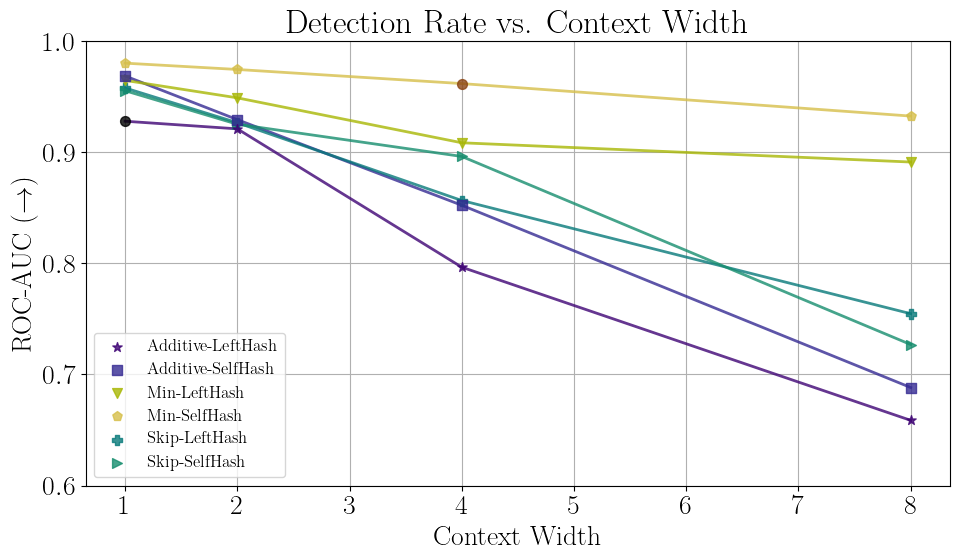

In [40]:
plot_scatter_data(
    data_df=df,
    x_col="context_width",
    y_col="attacked_z_score_roc_auc",
    x_name=r"Context Width",
    y_name=r"ROC-AUC $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    filter_list=filter_list,
    y_lim=(0.6,1.0),
    y_tick_spec=np.arange(0.6,1.05,0.1),
    # num_colors=4,
    # num_markers=4,
    num_colors=10,
    num_markers=10,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="lower left",
    num_cols=1,
    title="Detection Rate vs. Context Width",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [41]:
fig_name = "scheme_extended_logdiv_vs_ctx"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

df = df[df.apply(filter_raw_df_by_name, axis=1)]

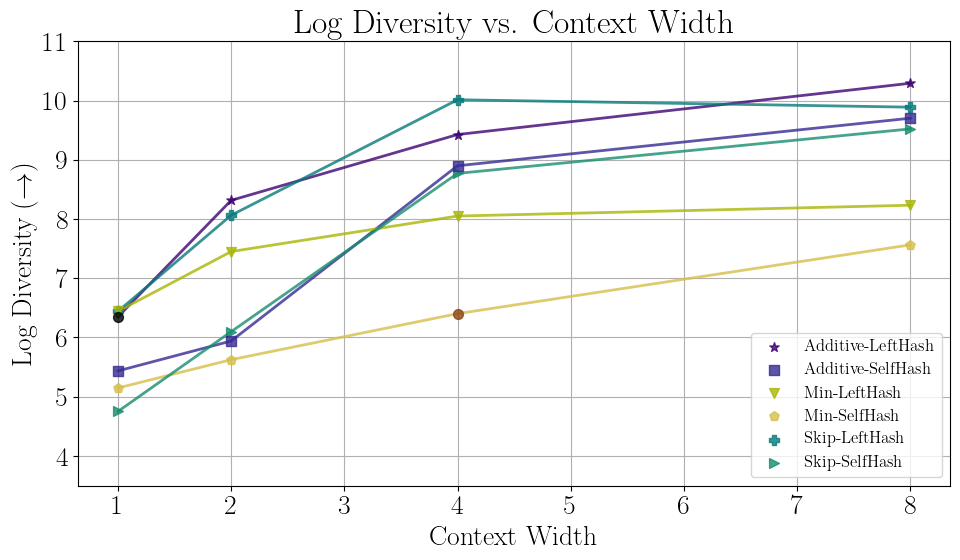

In [46]:
plot_scatter_data(
    data_df=df,
    x_col="context_width",
    y_col="f_200p25m25_w_wm_output_log_diversity_mean",
    x_name=r"Context Width",
    y_name=r"Log Diversity $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    filter_list=filter_list,
    y_lim=(3.5,11),
    y_tick_spec=np.arange(4,11.1,1),
    # num_colors=4,
    # num_markers=4,
    num_colors=10,
    num_markers=10,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="lower right",
    num_cols=1,
    title="Log Diversity vs. Context Width",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [47]:
def name_extractor(x):

    is_ff = "ff" in x
    is_simple = "simple" in x
    is_algo3 = "algorithm" in x
    is_self_salted = "True" in x
    if is_algo3:
        is_self_salted = True
    
    x = x.replace("scheme_ff-", "")
    x = x.replace("_gen_eval", "")
    x = x.replace("_50_200", "")
    x = x.replace("scheme_", "")
    x = x.replace("core_", "")
    x = x.replace("anchored_", "anchored-")
    x = x.replace("_prf-", "-prf_")
    x = x.replace("-True", "_True")
    x = x.replace("-False", "_False")

    x = x.replace("algorithm-3", "Algorithm3")
    x = x.replace("simple_1", "Simple_1")
    
    if is_self_salted:
        x = x.replace("-prf","-SelfHash")
    else:
        x = x.replace("-prf","-LeftHash")

    x = x.replace("minhash", "Min")
    x = x.replace("skipgram", "Skip")
    x = x.replace("additive", "Additive")
    x = x.replace("anchored", "Anchored")


    tup_x = x.split("_")
    tup_x[-1] = tup_x[-1].replace("-", ".")
    tup_x[-2] = tup_x[-2].replace("-", ".")

    
    # turn into a dict repr

    if is_ff:
        x_dict = {
            "prf_type": tup_x[0],
            "context_width": tup_x[1],
            "self_salt": tup_x[2],
            "gamma": tup_x[3],
            "delta": tup_x[4],
        }
    elif is_simple:
        x_dict = {
            "prf_type": tup_x[0],
            # "prf_type": "additive_prf",
            "context_width": tup_x[1],
            "self_salt": False,
            "gamma": tup_x[2],
            "delta": tup_x[3],
        }
    elif is_algo3:
        x_dict = {
            "prf_type": tup_x[0],
            "context_width": 4,
            "self_salt":True,
            "gamma": tup_x[1],
            "delta": tup_x[2],
        }
    else:
        raise ValueError(f"Invalid scheme name {x} found.")
    
    # return x_dict
    return ",".join([str(elm) for elm in x_dict.values()])


In [48]:
# color_order = [(typ,width) for width in [1,2,4,8] for typ in [
#     "Min-LeftHash",
#     "Skip-LeftHash",
#     "Additive-LeftHash",
# ]]
color_order = [
    "Additive-LeftHash",
    "Additive-SelfHash",
    "Anchored-Skip-LeftHash",
    "Anchored-Skip-SelfHash",
    "Skip-LeftHash",
    "Skip-SelfHash",
    "Anchored-Min-LeftHash",
    "Anchored-Min-SelfHash",
    "Min-LeftHash",
    "Min-SelfHash",
]

marker_order = color_order

# marker_order = [
#     [0.5,1.0],
#     [0.5,2.0],
#     [0.5,4.0],
#     [0.25,1.0],
#     [0.25,2.0],
#     [0.25,4.0],
#     [0.1,1.0],
#     [0.1,2.0],
#     [0.1,4.0],
# ]


def color_marker_map(x):

    x_tup = x.split(",")
    assert len(x_tup) == 5

    prf_type = x_tup[0]
    context_width = x_tup[1]
    self_salt = x_tup[2]
    gamma = x_tup[3]
    delta = x_tup[4]


    if prf_type == "Simple" or (prf_type == "Additive-LeftHash" and context_width=="1" and self_salt == "False"):
        color = "black"
        marker = "o"
    elif prf_type == "Algorithm3" or (prf_type=="Anchored-Min-SelfHash" and context_width=="4" and self_salt=="True"):
        # algo3
        color = "saddlebrown"
        marker = "o"
    else:
        color = color_order.index(prf_type)
        marker = marker_order.index(prf_type)
    return color, marker

filter_list = [
    "Simple,1,False,0-25,2-0",
    "Algorithm3,4,True,0-25,2-0",
]
    

In [49]:
fig_name = "scheme_extended_AUC_vs_ctx_all"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

In [50]:
df["Name"].apply(name_extractor)

0                     Simple,1,False,0-25,2-0
1               Skip-SelfHash,8,True,0-25,2-0
2              Skip-LeftHash,8,False,0-25,2-0
3               Skip-SelfHash,4,True,0-25,2-0
4              Skip-LeftHash,4,False,0-25,2-0
5               Skip-SelfHash,2,True,0-25,2-0
6              Skip-LeftHash,2,False,0-25,2-0
7               Skip-SelfHash,1,True,0-25,2-0
8              Skip-LeftHash,1,False,0-25,2-0
9                Min-SelfHash,8,True,0-25,2-0
10              Min-LeftHash,8,False,0-25,2-0
11               Min-SelfHash,4,True,0-25,2-0
12              Min-LeftHash,4,False,0-25,2-0
13               Min-SelfHash,2,True,0-25,2-0
14              Min-LeftHash,2,False,0-25,2-0
15               Min-SelfHash,1,True,0-25,2-0
16              Min-LeftHash,1,False,0-25,2-0
17     Anchored-Skip-SelfHash,8,True,0-25,2-0
18    Anchored-Skip-LeftHash,8,False,0-25,2-0
19     Anchored-Skip-SelfHash,4,True,0-25,2-0
20    Anchored-Skip-LeftHash,4,False,0-25,2-0
21     Anchored-Skip-SelfHash,2,Tr

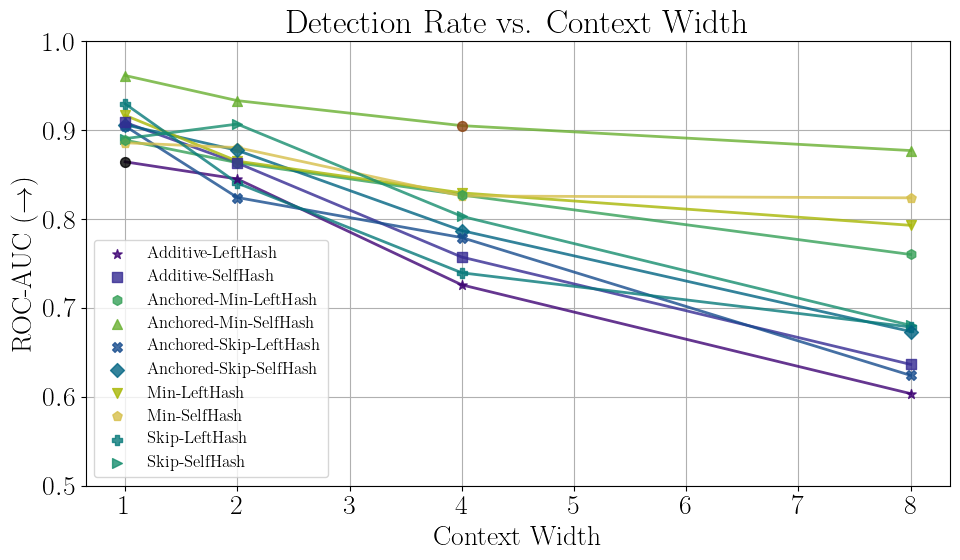

In [51]:
plot_scatter_data(
    data_df=df,
    x_col="context_width",
    y_col="attacked_z_score_roc_auc",
    x_name=r"Context Width",
    y_name=r"ROC-AUC $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,2],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    filter_list=filter_list,
    y_lim=(0.5,1.0),
    y_tick_spec=np.arange(0.5,1.05,0.1),
    num_colors=10,
    num_markers=10,
    marker_size=50,
    figure_size=(10,6),
    plot_inferred_series=True,
    inferred_series_linestyle="solid",
    inferred_series_linewidth=2,
    legend_loc="lower left",
    num_cols=1,
    title="Detection Rate vs. Context Width",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [27]:
fig_name = "scheme_extended_clean_psp_vs_attacked_auc_pareto"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

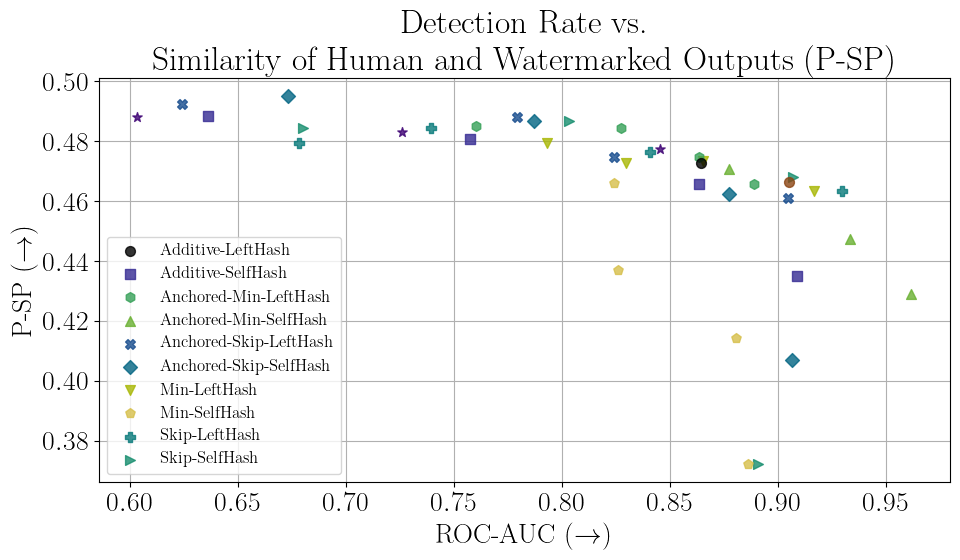

In [28]:
plot_scatter_data(
    data_df=df,
    x_col="attacked_z_score_roc_auc",
    y_col="f_200p25m25_baseline_completion_vs_w_wm_output_p_sp_mean",
    x_name=r"ROC-AUC $(\rightarrow)$",
    y_name=r"P-SP $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,2],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    filter_list=filter_list,
    num_colors=10,
    num_markers=10,
    marker_size=50,
    figure_size=(10,6),
    # plot_inferred_series=True,
    # inferred_series_linestyle="solid",
    # inferred_series_linewidth=2,
    # infer_sort_by_x=False,
    legend_loc="lower left",
    num_cols=1,
    title="Detection Rate vs.\nSimilarity of Human and Watermarked Outputs (P-SP)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)